## Zoe Markovits, Dan Grenell

## CSC 84020 Final Project

## 1. Data Pre-Processing

In [0]:
import pandas as pd
import numpy as np
import cv2
import random
import shutil
import os
from glob import glob
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
!unzip -q gdrive/My\ Drive/asl_alphabet.zip -d /content/

In [0]:
base_directory = '/content/asl_alphabet/'
train_directory = '/content/asl_alphabet/train'
validation_directory = '/content/asl_alphabet/validation'
test_directory = '/content/asl_alphabet/test'

In [5]:
from keras.preprocessing.image import ImageDataGenerator

data_generator = ImageDataGenerator(rescale=1./255)

train_generator = data_generator.flow_from_directory(train_directory, target_size=(64, 64), batch_size=64)

validation_generator = data_generator.flow_from_directory(validation_directory, target_size=(64, 64), batch_size=64)

test_generator = data_generator.flow_from_directory(test_directory, target_size=(64, 64), batch_size=64)

Using TensorFlow backend.


Found 60900 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.
Found 13050 images belonging to 29 classes.


## 2. Build CNN Model 

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.activations import relu
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras import regularizers

In [0]:
def build_model(KernelSize = (3,3), DropoutSize = 0.2, BatchNorm = False):
    if BatchNorm:
        model = Sequential()
        model.add(Conv2D(64, input_shape=(64, 64, 3), kernel_size=KernelSize, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(64, kernel_size=KernelSize, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        model.add(Conv2D(128, kernel_size=KernelSize, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(256, kernel_size=KernelSize, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(BatchNormalization())
        model.add(Flatten())
        model.add(Dropout(DropoutSize))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(29, activation='softmax'))
    else:
        model = Sequential()
        model.add(Conv2D(64, input_shape=(64, 64, 3), kernel_size=KernelSize, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
        model.add(Conv2D(64, kernel_size=KernelSize, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, kernel_size=KernelSize, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
        model.add(Conv2D(256, kernel_size=KernelSize, kernel_regularizer=regularizers.l2(0.01), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dropout(DropoutSize))
        model.add(Dense(512, activation='relu'))
        model.add(Dense(29, activation='softmax'))
    
    return model

In [0]:
def plot_metrics(history, model_name = "Model Name"):
    fig = plt.figure(figsize=(15,5))
    
    ax1 = plt.subplot(121)
    ax1.set_title(f'Accuracy for {model_name}')
    ax1.plot(list(range(15)), history.history['acc'], label = 'Training Accuracy')
    ax1.plot(list(range(15)), history.history['val_acc'], label = 'Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.xticks(list(range(0, 15 + 1, 5)))
    plt.legend(['Train','Validation'], loc='upper left')
    
    ax2 = plt.subplot(122)
    ax2.set_title(f'Loss for {model_name}')
    ax2.plot(list(range(15)), history.history['loss'], label = 'Training Loss')
    ax2.plot(list(range(15)), history.history['val_loss'], label = 'Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(list(range(0, 15 + 1, 5)))
    plt.legend(['Train','Validation'], loc='upper left')
    
    return plt.show()

#### Baseline model: no tuning of parameters, kernel regularization, dropout, or batch normalization

In [0]:
model_base = Sequential()
model_base.add(Conv2D(64, (3, 3), input_shape=(64, 64, 3), activation='relu'))
model_base.add(Conv2D(64, (3, 3), activation='relu'))
model_base.add(MaxPooling2D((2, 2)))
model_base.add(Conv2D(64, (3, 3), activation='relu'))
model_base.add(Conv2D(128, (3, 3), activation='relu'))
model_base.add(MaxPooling2D((2, 2)))
model_base.add(Flatten())
model_base.add(Dense(512, activation='relu'))
model_base.add(Dense(29, activation='softmax'))

In [0]:
model_base.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [13]:
history_baseline = model_base.fit_generator(train_generator, validation_data=validation_generator, epochs=5)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





952/952 [==============================] - 92s 97ms/step - loss: 3.0749 - acc: 0.1318 - val_loss: 2.5555 - val_acc: 0.2750
Epoch 2/5
952/952 [==============================] - 83s 87ms/step - loss: 1.7000 - acc: 0.4904 - val_loss: 0.8788 - val_acc: 0.7136
Epoch 3/5
952/952 [==============================] - 83s 87ms/step - loss: 0.5757 - acc: 0.8172 - val_loss: 0.3180 - val_acc: 0.8999
Epoch 4/5
952/952 [==============================] - 83s 87ms/step - loss: 0.2436 - acc: 0.9214 - val_loss: 0.1786 - val_acc: 0.9455
Epoch 5/5
952/952 [==============================] - 82s 86ms/step - loss: 0.1297 - acc: 0.9587 - val_loss: 0.1016 - val_acc: 0.9677


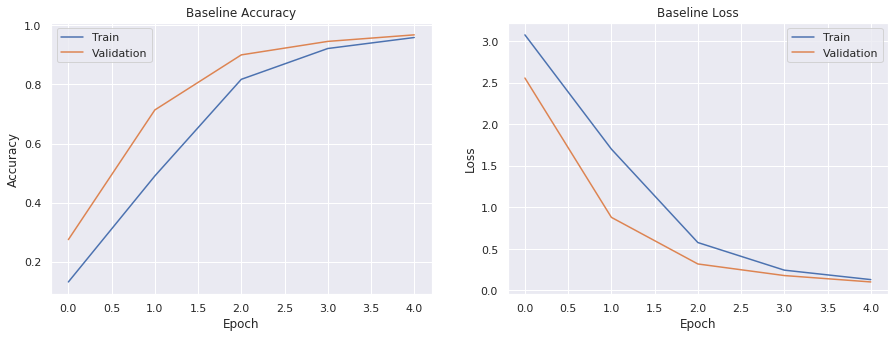

In [113]:
fig = plt.figure(figsize=(15,5))
    
ax1 = plt.subplot(121)
ax1.set_title('Baseline Accuracy')
ax1.plot(history_baseline.history['acc'], label = 'Training Accuracy')
ax1.plot(history_baseline.history['val_acc'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Validation'])

ax2 = plt.subplot(122)
ax2.set_title('Baseline Loss')
ax2.plot(history_baseline.history['loss'], label = 'Training Loss')
ax2.plot(history_baseline.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train','Validation'])

plt.show()

## 3. Exploring Hyper-parameters

#### Dropout size is either 0.3, 0.4, or 0.5, kernel size is either 3x3 or 5x5, and add batch normalization layers or leave them out

### First Model: Dropout = 0.3, Kernel Size = 3 x 3, and Batch Normalization 


In [15]:
model1 = build_model(DropoutSize = 0.3, KernelSize=(3,3), BatchNorm = True)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
history1 = model1.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 92s 97ms/step - loss: 16.1191 - acc: 0.0596 - val_loss: 15.7019 - val_acc: 0.0608
Epoch 2/15
952/952 [==============================] - 89s 93ms/step - loss: 15.5734 - acc: 0.0546 - val_loss: 15.3432 - val_acc: 0.0539
Epoch 3/15
952/952 [==============================] - 89s 93ms/step - loss: 16.1692 - acc: 0.0453 - val_loss: 15.8639 - val_acc: 0.0519
Epoch 4/15
952/952 [==============================] - 88s 92ms/step - loss: 16.1142 - acc: 0.0460 - val_loss: 16.3931 - val_acc: 0.0410
Epoch 5/15
952/952 [==============================] - 88s 92ms/step - loss: 16.3662 - acc: 0.0450 - val_loss: 16.1750 - val_acc: 0.0528
Epoch 6/15
952/952 [==============================] - 90s 95ms/step - loss: 16.0421 - acc: 0.0455 - val_loss: 16.2413 - val_acc: 0.0375
Epoch 7/15
952/952 [==============================] - 88s 93ms/step - loss: 16.5403 - acc: 0.0385 - val_loss: 16.3590 - val_acc: 0.0503
Epoch 8/15
952/952 [============================

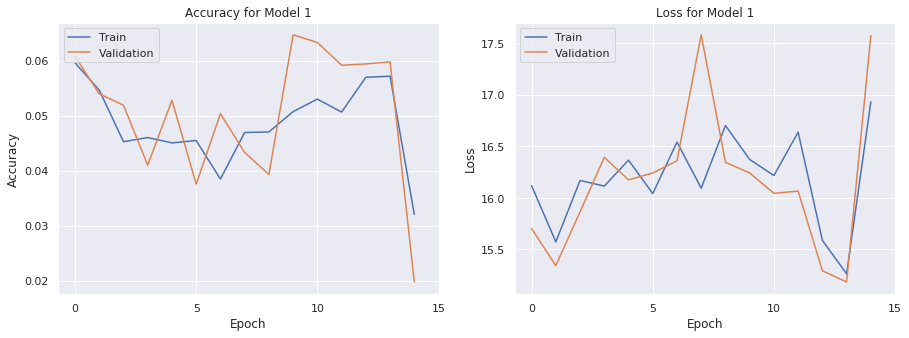

In [32]:
plot_metrics(history1, model_name = "Model 1")

### Second Model: Dropout = 0.3, Kernel Size = 5 x 5, and Batch Normalization 

In [0]:
model2 = build_model(DropoutSize = 0.3, KernelSize=(5,5), BatchNorm = True)

In [0]:
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
history2 = model2.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 90s 94ms/step - loss: 2.5336 - acc: 0.6247 - val_loss: 3.1693 - val_acc: 0.4754
Epoch 2/15
952/952 [==============================] - 87s 91ms/step - loss: 0.8573 - acc: 0.8606 - val_loss: 1.3023 - val_acc: 0.7379
Epoch 3/15
952/952 [==============================] - 87s 91ms/step - loss: 0.7127 - acc: 0.9043 - val_loss: 1.3164 - val_acc: 0.7573
Epoch 4/15
952/952 [==============================] - 86s 91ms/step - loss: 0.6498 - acc: 0.9231 - val_loss: 3.3013 - val_acc: 0.5235
Epoch 5/15
952/952 [==============================] - 86s 91ms/step - loss: 0.5820 - acc: 0.9361 - val_loss: 1.7289 - val_acc: 0.6920
Epoch 6/15
952/952 [==============================] - 86s 90ms/step - loss: 0.5226 - acc: 0.9453 - val_loss: 2.9612 - val_acc: 0.6508
Epoch 7/15
952/952 [==============================] - 86s 90ms/step - loss: 0.4856 - acc: 0.9518 - val_loss: 1.1491 - val_acc: 0.8334
Epoch 8/15
952/952 [==============================] - 86s 90ms

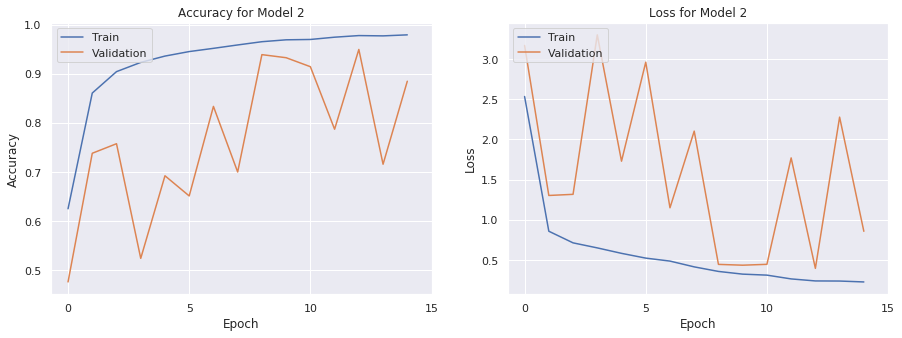

In [33]:
plot_metrics(history2, model_name = "Model 2")

### Third Model: Dropout = 0.3, Kernel Size 3 x 3, and No Batch Normalization 

In [0]:
model3 = build_model(DropoutSize = 0.3, KernelSize=(3,3), BatchNorm = False)

In [0]:
model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [28]:
history3 = model3.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 88s 92ms/step - loss: 1.4253 - acc: 0.6372 - val_loss: 0.5392 - val_acc: 0.8849
Epoch 2/15
952/952 [==============================] - 86s 90ms/step - loss: 0.4226 - acc: 0.9171 - val_loss: 0.3265 - val_acc: 0.9487
Epoch 3/15
952/952 [==============================] - 85s 90ms/step - loss: 0.2939 - acc: 0.9521 - val_loss: 0.2470 - val_acc: 0.9661
Epoch 4/15
952/952 [==============================] - 85s 90ms/step - loss: 0.2433 - acc: 0.9647 - val_loss: 0.2244 - val_acc: 0.9713
Epoch 5/15
952/952 [==============================] - 85s 90ms/step - loss: 0.2099 - acc: 0.9718 - val_loss: 0.1866 - val_acc: 0.9774
Epoch 6/15
952/952 [==============================] - 85s 89ms/step - loss: 0.1798 - acc: 0.9781 - val_loss: 0.1658 - val_acc: 0.9816
Epoch 7/15
952/952 [==============================] - 85s 89ms/step - loss: 0.1613 - acc: 0.9823 - val_loss: 0.1735 - val_acc: 0.9741
Epoch 8/15
952/952 [==============================] - 85s 89ms

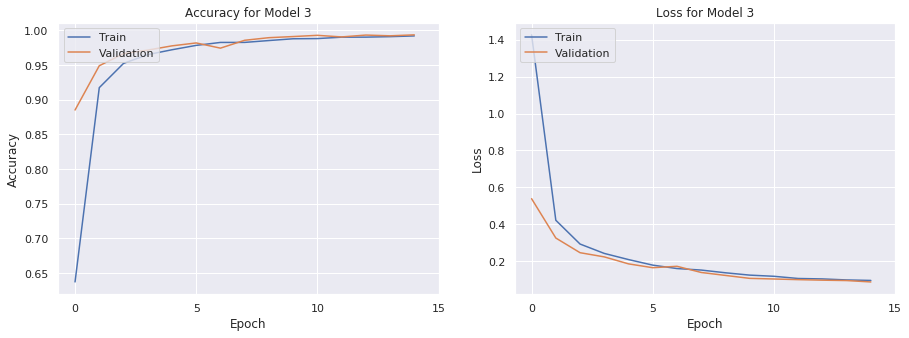

In [34]:
plot_metrics(history3, model_name = "Model 3")

### Fourth Model: Dropout = 0.3, Kernel Size 5 x 5, and No Batch Normalization 

In [0]:
model4 = build_model(DropoutSize = 0.3, KernelSize=(5,5), BatchNorm = False)

In [0]:
model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
history4 = model4.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 88s 93ms/step - loss: 2.2144 - acc: 0.3764 - val_loss: 0.9901 - val_acc: 0.6959
Epoch 2/15
952/952 [==============================] - 85s 89ms/step - loss: 0.7992 - acc: 0.7644 - val_loss: 0.5888 - val_acc: 0.8358
Epoch 3/15
952/952 [==============================] - 85s 89ms/step - loss: 0.5152 - acc: 0.8597 - val_loss: 0.3343 - val_acc: 0.9303
Epoch 4/15
952/952 [==============================] - 84s 89ms/step - loss: 0.3981 - acc: 0.9023 - val_loss: 0.2720 - val_acc: 0.9487
Epoch 5/15
952/952 [==============================] - 84s 88ms/step - loss: 0.3433 - acc: 0.9201 - val_loss: 0.2393 - val_acc: 0.9585
Epoch 6/15
952/952 [==============================] - 85s 89ms/step - loss: 0.2995 - acc: 0.9351 - val_loss: 0.2177 - val_acc: 0.9642
Epoch 7/15
952/952 [==============================] - 84s 88ms/step - loss: 0.2780 - acc: 0.9410 - val_loss: 0.1874 - val_acc: 0.9758
Epoch 8/15
952/952 [==============================] - 84s 89ms

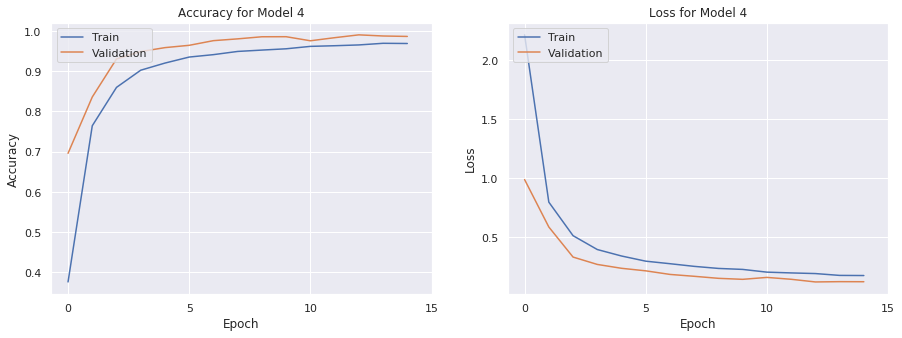

In [38]:
plot_metrics(history4, model_name = "Model 4")

### Fifth Model: Dropout = 0.4, Kernel Size 3 x 3, and Batch Normalization 

In [0]:
model5 = build_model(DropoutSize = 0.4, KernelSize=(3,3), BatchNorm = True)

In [0]:
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [41]:
history5 = model5.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 90s 95ms/step - loss: 4.5988 - acc: 0.4946 - val_loss: 6.6608 - val_acc: 0.2794
Epoch 2/15
952/952 [==============================] - 89s 93ms/step - loss: 0.8411 - acc: 0.8265 - val_loss: 2.7559 - val_acc: 0.5920
Epoch 3/15
952/952 [==============================] - 89s 94ms/step - loss: 0.5856 - acc: 0.9046 - val_loss: 1.4020 - val_acc: 0.7892
Epoch 4/15
952/952 [==============================] - 89s 94ms/step - loss: 0.5165 - acc: 0.9293 - val_loss: 1.1513 - val_acc: 0.7848
Epoch 5/15
952/952 [==============================] - 88s 93ms/step - loss: 0.5031 - acc: 0.9382 - val_loss: 3.1555 - val_acc: 0.6522
Epoch 6/15
952/952 [==============================] - 88s 92ms/step - loss: 0.4338 - acc: 0.9508 - val_loss: 0.6971 - val_acc: 0.8825
Epoch 7/15
952/952 [==============================] - 88s 93ms/step - loss: 0.4082 - acc: 0.9571 - val_loss: 1.7307 - val_acc: 0.7825
Epoch 8/15
952/952 [==============================] - 87s 92ms

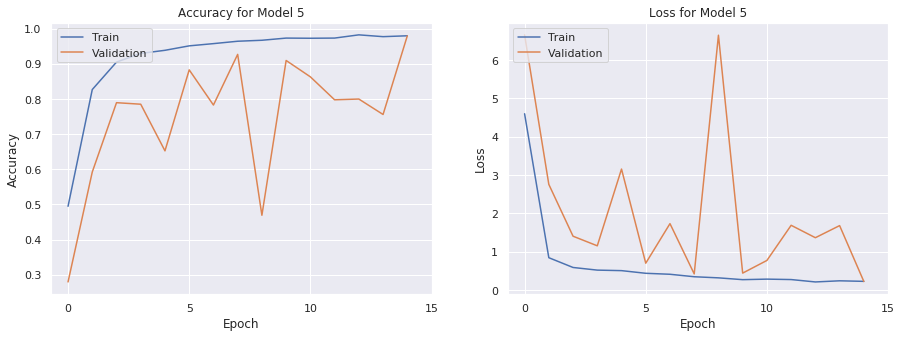

In [42]:
plot_metrics(history5, model_name = "Model 5")

### Sixth Model: Dropout = 0.4, Kernel Size 5 x 5, and Batch Normalization 

In [0]:
model6 = build_model(DropoutSize = 0.4, KernelSize=(5,5), BatchNorm = True)

In [0]:
model6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [45]:
history6 = model6.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 89s 94ms/step - loss: 2.7985 - acc: 0.6040 - val_loss: 4.2447 - val_acc: 0.3897
Epoch 2/15
952/952 [==============================] - 86s 90ms/step - loss: 0.8662 - acc: 0.8599 - val_loss: 2.1662 - val_acc: 0.5821
Epoch 3/15
952/952 [==============================] - 86s 90ms/step - loss: 0.7760 - acc: 0.8997 - val_loss: 11.0953 - val_acc: 0.2395
Epoch 4/15
952/952 [==============================] - 85s 90ms/step - loss: 0.7429 - acc: 0.9178 - val_loss: 7.8326 - val_acc: 0.3592
Epoch 5/15
952/952 [==============================] - 86s 90ms/step - loss: 0.6390 - acc: 0.9329 - val_loss: 2.0022 - val_acc: 0.7297
Epoch 6/15
952/952 [==============================] - 86s 90ms/step - loss: 0.5963 - acc: 0.9400 - val_loss: 2.8201 - val_acc: 0.5931
Epoch 7/15
952/952 [==============================] - 86s 90ms/step - loss: 0.5159 - acc: 0.9506 - val_loss: 1.9609 - val_acc: 0.7347
Epoch 8/15
952/952 [==============================] - 86s 90m

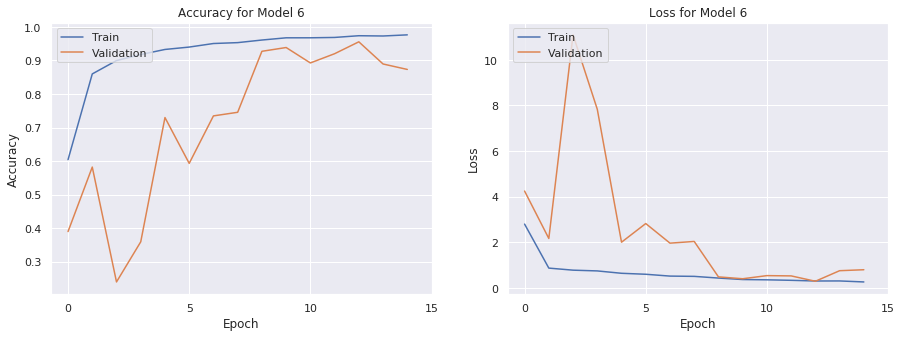

In [46]:
plot_metrics(history6, model_name = "Model 6")

### Seventh Model: Dropout = 0.4, Kernel Size 3 x 3, and No Batch Normalization 

In [0]:
model7 = build_model(DropoutSize = 0.4, KernelSize=(3,3), BatchNorm = False)

In [0]:
model7.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
history7 = model7.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 87s 92ms/step - loss: 1.5332 - acc: 0.5991 - val_loss: 0.5347 - val_acc: 0.8761
Epoch 2/15
952/952 [==============================] - 84s 89ms/step - loss: 0.4536 - acc: 0.8962 - val_loss: 0.2839 - val_acc: 0.9515
Epoch 3/15
952/952 [==============================] - 84s 88ms/step - loss: 0.3168 - acc: 0.9396 - val_loss: 0.2288 - val_acc: 0.9684
Epoch 4/15
952/952 [==============================] - 84s 89ms/step - loss: 0.2583 - acc: 0.9546 - val_loss: 0.1878 - val_acc: 0.9804
Epoch 5/15
952/952 [==============================] - 84s 89ms/step - loss: 0.2221 - acc: 0.9644 - val_loss: 0.1742 - val_acc: 0.9807
Epoch 6/15
952/952 [==============================] - 85s 89ms/step - loss: 0.2031 - acc: 0.9674 - val_loss: 0.1671 - val_acc: 0.9818
Epoch 7/15
952/952 [==============================] - 84s 88ms/step - loss: 0.1809 - acc: 0.9745 - val_loss: 0.1420 - val_acc: 0.9866
Epoch 8/15
952/952 [==============================] - 84s 88ms

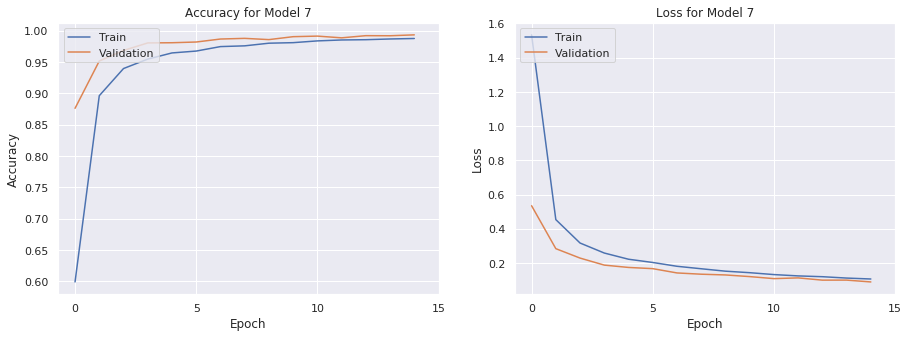

In [50]:
plot_metrics(history7, model_name = "Model 7")

### Eigth Model: Dropout = 0.4, Kernel Size 5 x 5, and No Batch Normalization 

In [0]:
model8 = build_model(DropoutSize = 0.4, KernelSize=(5,5), BatchNorm = False)

In [0]:
model8.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [99]:
history8 = model8.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 93s 98ms/step - loss: 3.5078 - acc: 0.0326 - val_loss: 3.3739 - val_acc: 0.0345
Epoch 2/15
952/952 [==============================] - 87s 92ms/step - loss: 3.3694 - acc: 0.0335 - val_loss: 3.3675 - val_acc: 0.0345
Epoch 3/15
952/952 [==============================] - 86s 91ms/step - loss: 3.3676 - acc: 0.0315 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 4/15
952/952 [==============================] - 87s 91ms/step - loss: 3.3676 - acc: 0.0326 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 5/15
952/952 [==============================] - 86s 90ms/step - loss: 3.3676 - acc: 0.0330 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 6/15
952/952 [==============================] - 86s 90ms/step - loss: 3.3676 - acc: 0.0322 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 7/15
952/952 [==============================] - 85s 90ms/step - loss: 3.3676 - acc: 0.0334 - val_loss: 3.3673 - val_acc: 0.0345
Epoch 8/15
952/952 [==============================] - 86s 90ms

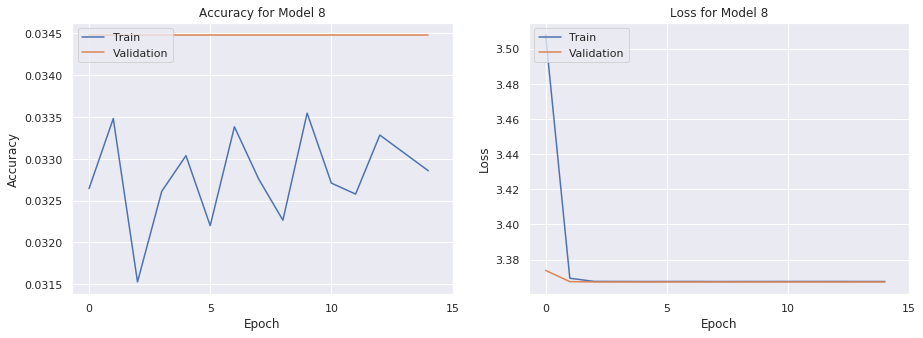

In [100]:
plot_metrics(history8, model_name = "Model 8")

### Ninth Model: Dropout = 0.5, Kernel Size 3 x 3, and Batch Normalization 

In [0]:
model9 = build_model(DropoutSize = 0.5, KernelSize=(3,3), BatchNorm = True)

In [0]:
model9.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
history9 = model9.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 93s 97ms/step - loss: 4.0014 - acc: 0.5449 - val_loss: 3.2710 - val_acc: 0.4369
Epoch 2/15
952/952 [==============================] - 89s 94ms/step - loss: 0.7777 - acc: 0.8478 - val_loss: 1.0577 - val_acc: 0.7828
Epoch 3/15
952/952 [==============================] - 89s 93ms/step - loss: 0.6297 - acc: 0.9004 - val_loss: 1.4764 - val_acc: 0.7707
Epoch 4/15
952/952 [==============================] - 91s 95ms/step - loss: 0.5824 - acc: 0.9230 - val_loss: 1.1970 - val_acc: 0.7854
Epoch 5/15
952/952 [==============================] - 92s 97ms/step - loss: 0.5288 - acc: 0.9372 - val_loss: 4.4888 - val_acc: 0.5943
Epoch 6/15
952/952 [==============================] - 93s 97ms/step - loss: 0.4724 - acc: 0.9461 - val_loss: 1.2994 - val_acc: 0.7945
Epoch 7/15
952/952 [==============================] - 93s 98ms/step - loss: 0.4604 - acc: 0.9521 - val_loss: 1.0449 - val_acc: 0.8204
Epoch 8/15
952/952 [==============================] - 93s 98ms

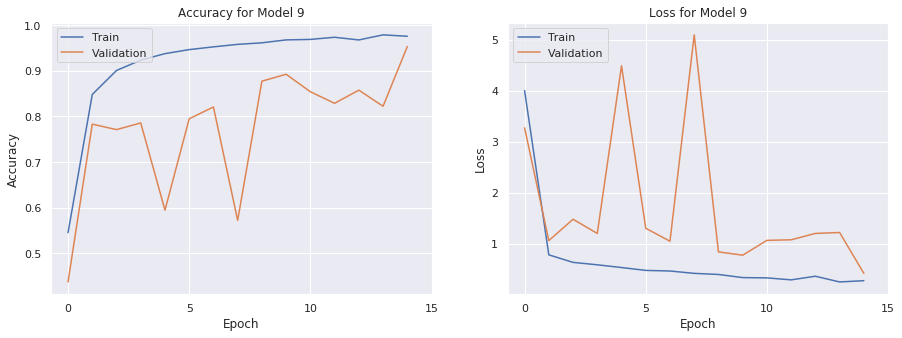

In [61]:
plot_metrics(history9, model_name = "Model 9")

### Tenth Model: Dropout = 0.5, Kernel Size 5 x 5, and Batch Normalization 

In [0]:
model10 = build_model(DropoutSize = 0.5, KernelSize=(5,5), BatchNorm = True)

In [0]:
model10.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [101]:
history10 = model10.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 93s 97ms/step - loss: 0.4246 - acc: 0.9618 - val_loss: 11.7262 - val_acc: 0.2422
Epoch 2/15
952/952 [==============================] - 93s 97ms/step - loss: 0.3834 - acc: 0.9669 - val_loss: 0.4091 - val_acc: 0.9434
Epoch 3/15
952/952 [==============================] - 92s 97ms/step - loss: 0.3584 - acc: 0.9694 - val_loss: 1.3684 - val_acc: 0.7997
Epoch 4/15
952/952 [==============================] - 93s 97ms/step - loss: 0.3415 - acc: 0.9711 - val_loss: 1.3733 - val_acc: 0.8144
Epoch 5/15
952/952 [==============================] - 93s 97ms/step - loss: 0.3330 - acc: 0.9729 - val_loss: 1.1667 - val_acc: 0.8193
Epoch 6/15
952/952 [==============================] - 93s 98ms/step - loss: 0.2972 - acc: 0.9746 - val_loss: 1.1854 - val_acc: 0.8369
Epoch 7/15
952/952 [==============================] - 93s 98ms/step - loss: 0.2885 - acc: 0.9771 - val_loss: 1.1582 - val_acc: 0.7959
Epoch 8/15
952/952 [==============================] - 93s 98m

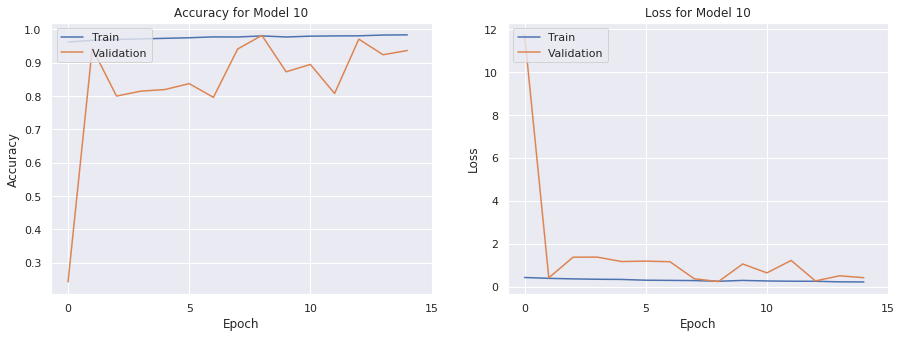

In [102]:
plot_metrics(history10, model_name = "Model 10")

### Eleventh Model: Dropout = 0.5, Kernel Size 3 x 3, and No Batch Normalization 

In [0]:
model11 = build_model(DropoutSize = 0.5, KernelSize=(3,3), BatchNorm = False)

In [0]:
model11.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [117]:
history11 = model11.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 95s 100ms/step - loss: 1.5352 - acc: 0.5794 - val_loss: 0.5951 - val_acc: 0.8434
Epoch 2/15
952/952 [==============================] - 90s 95ms/step - loss: 0.5402 - acc: 0.8596 - val_loss: 0.4206 - val_acc: 0.8970
Epoch 3/15
952/952 [==============================] - 90s 95ms/step - loss: 0.3770 - acc: 0.9123 - val_loss: 0.2898 - val_acc: 0.9407
Epoch 4/15
952/952 [==============================] - 91s 95ms/step - loss: 0.2968 - acc: 0.9371 - val_loss: 0.2284 - val_acc: 0.9599
Epoch 5/15
952/952 [==============================] - 91s 95ms/step - loss: 0.2610 - acc: 0.9474 - val_loss: 0.1886 - val_acc: 0.9716
Epoch 6/15
952/952 [==============================] - 91s 96ms/step - loss: 0.2189 - acc: 0.9594 - val_loss: 0.2017 - val_acc: 0.9649
Epoch 7/15
952/952 [==============================] - 91s 96ms/step - loss: 0.2078 - acc: 0.9609 - val_loss: 0.1698 - val_acc: 0.9766
Epoch 8/15
952/952 [==============================] - 91s 96m

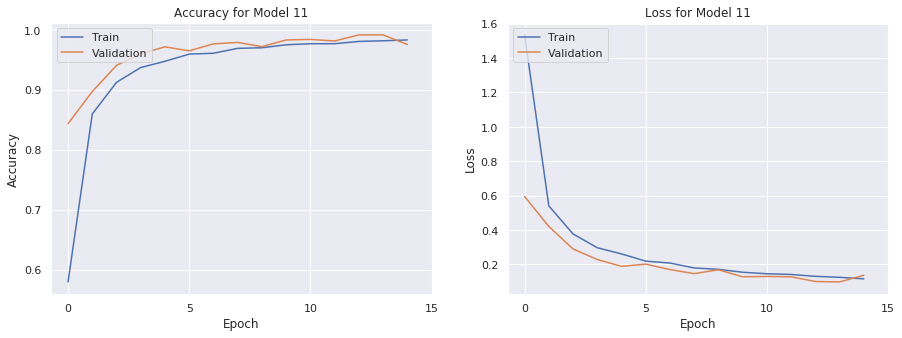

In [118]:
plot_metrics(history11, model_name = "Model 11")

### Twelfth Model: Dropout = 0.5, Kernel Size 5 x 5, and No Batch Normalization 

In [0]:
model12 = build_model(DropoutSize = 0.5, KernelSize=(5,5), BatchNorm = False)

In [0]:
model12.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [121]:
history12 = model12.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 96s 101ms/step - loss: 2.1928 - acc: 0.3684 - val_loss: 0.8565 - val_acc: 0.7569
Epoch 2/15
952/952 [==============================] - 91s 95ms/step - loss: 0.8899 - acc: 0.7315 - val_loss: 0.5162 - val_acc: 0.8674
Epoch 3/15
952/952 [==============================] - 91s 95ms/step - loss: 0.6339 - acc: 0.8134 - val_loss: 0.3339 - val_acc: 0.9212
Epoch 4/15
952/952 [==============================] - 91s 95ms/step - loss: 0.5096 - acc: 0.8546 - val_loss: 0.2701 - val_acc: 0.9457
Epoch 5/15
952/952 [==============================] - 91s 96ms/step - loss: 0.4484 - acc: 0.8753 - val_loss: 0.2489 - val_acc: 0.9482
Epoch 6/15
952/952 [==============================] - 91s 95ms/step - loss: 0.4039 - acc: 0.8924 - val_loss: 0.2177 - val_acc: 0.9598
Epoch 7/15
952/952 [==============================] - 91s 96ms/step - loss: 0.3691 - acc: 0.9033 - val_loss: 0.1986 - val_acc: 0.9670
Epoch 8/15
952/952 [==============================] - 91s 96m

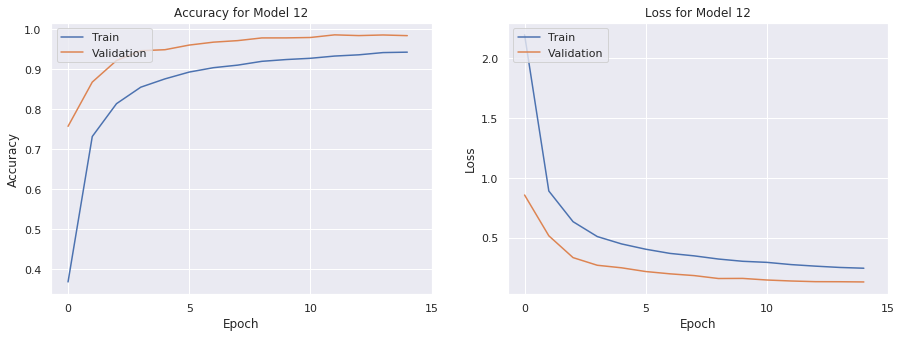

In [122]:
plot_metrics(history12, model_name = "Model 12")

## 4. Exploring Optimizers

#### From Part 3 our best model was model 3 which has Dropout = 0.3, Kernel Size 3 x 3, and No Batch Normalization. We will use this model to test out various optimizers

In [0]:
top_model = build_model(DropoutSize = 0.3, KernelSize=(3,3), BatchNorm = False)

In [124]:
top_model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 26, 26, 256)       295168    
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
flatten_23 (Flatten)         (None, 43264)           

### A. Stochastic Gradient Descent

In [0]:
top_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [111]:
history_sgd = top_model.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 92s 97ms/step - loss: 5.8700 - acc: 0.1126 - val_loss: 5.0826 - val_acc: 0.1999
Epoch 2/15
952/952 [==============================] - 88s 93ms/step - loss: 4.0954 - acc: 0.3569 - val_loss: 2.9726 - val_acc: 0.5850
Epoch 3/15
952/952 [==============================] - 88s 93ms/step - loss: 2.3038 - acc: 0.7143 - val_loss: 1.6975 - val_acc: 0.8460
Epoch 4/15
952/952 [==============================] - 88s 92ms/step - loss: 1.4535 - acc: 0.8650 - val_loss: 1.1712 - val_acc: 0.9137
Epoch 5/15
952/952 [==============================] - 86s 91ms/step - loss: 1.0147 - acc: 0.9225 - val_loss: 0.8543 - val_acc: 0.9439
Epoch 6/15
952/952 [==============================] - 87s 92ms/step - loss: 0.7507 - acc: 0.9492 - val_loss: 0.6292 - val_acc: 0.9668
Epoch 7/15
952/952 [==============================] - 86s 90ms/step - loss: 0.6455 - acc: 0.9513 - val_loss: 0.5445 - val_acc: 0.9633
Epoch 8/15
952/952 [==============================] - 85s 89ms

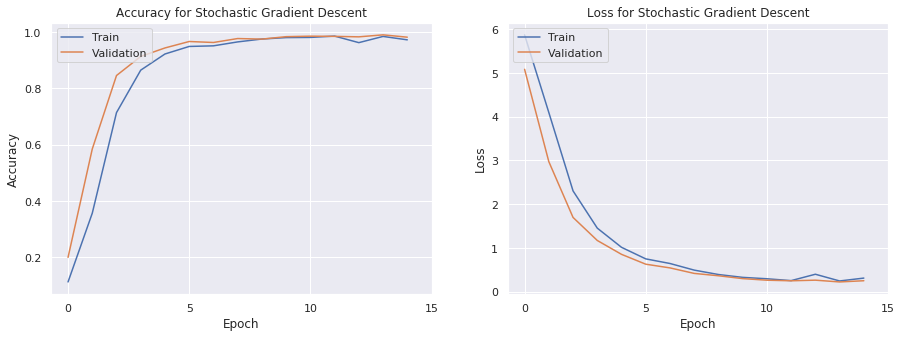

In [112]:
plot_metrics(history_sgd, model_name = "Stochastic Gradient Descent")

### B. RMSProp

In [0]:
top_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [18]:
history_rmsprop = top_model.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 84s 88ms/step - loss: 1.5634 - acc: 0.6001 - val_loss: 0.5250 - val_acc: 0.8784
Epoch 2/15
952/952 [==============================] - 82s 87ms/step - loss: 0.3952 - acc: 0.9145 - val_loss: 0.2419 - val_acc: 0.9621
Epoch 3/15
952/952 [==============================] - 83s 87ms/step - loss: 0.2406 - acc: 0.9550 - val_loss: 0.1691 - val_acc: 0.9744
Epoch 4/15
952/952 [==============================] - 83s 87ms/step - loss: 0.1750 - acc: 0.9699 - val_loss: 0.1345 - val_acc: 0.9822
Epoch 5/15
952/952 [==============================] - 85s 89ms/step - loss: 0.1414 - acc: 0.9775 - val_loss: 0.1073 - val_acc: 0.9875
Epoch 6/15
952/952 [==============================] - 85s 90ms/step - loss: 0.1220 - acc: 0.9816 - val_loss: 0.0976 - val_acc: 0.9890
Epoch 7/15
952/952 [==============================] - 86s 90ms/step - loss: 0.1016 - acc: 0.9860 - val_loss: 0.1090 - val_acc: 0.9814
Epoch 8/15
952/952 [==============================] - 87s 91ms

In [0]:
top_model.save('rmsprop_model_top')

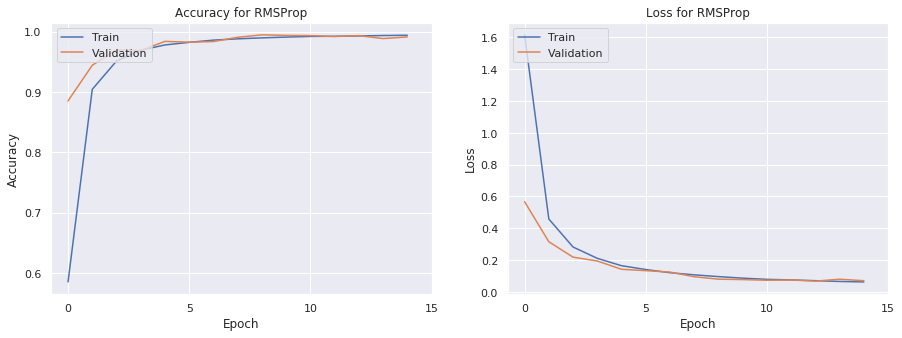

In [78]:
plot_metrics(history_rmsprop, model_name = "RMSProp")

### C. AdaGrad

In [0]:
top_model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

In [126]:
history_adagrad = top_model.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 91s 96ms/step - loss: 2.2346 - acc: 0.3710 - val_loss: 1.2355 - val_acc: 0.6330
Epoch 2/15
952/952 [==============================] - 87s 92ms/step - loss: 1.0637 - acc: 0.6833 - val_loss: 0.7184 - val_acc: 0.8043
Epoch 3/15
952/952 [==============================] - 86s 91ms/step - loss: 0.7595 - acc: 0.7807 - val_loss: 0.5263 - val_acc: 0.8666
Epoch 4/15
952/952 [==============================] - 89s 93ms/step - loss: 0.6129 - acc: 0.8304 - val_loss: 0.4386 - val_acc: 0.8925
Epoch 5/15
952/952 [==============================] - 90s 95ms/step - loss: 0.5272 - acc: 0.8594 - val_loss: 0.3727 - val_acc: 0.9179
Epoch 6/15
952/952 [==============================] - 90s 95ms/step - loss: 0.4696 - acc: 0.8783 - val_loss: 0.3311 - val_acc: 0.9366
Epoch 7/15
952/952 [==============================] - 91s 95ms/step - loss: 0.4284 - acc: 0.8939 - val_loss: 0.3042 - val_acc: 0.9426
Epoch 8/15
952/952 [==============================] - 90s 95ms

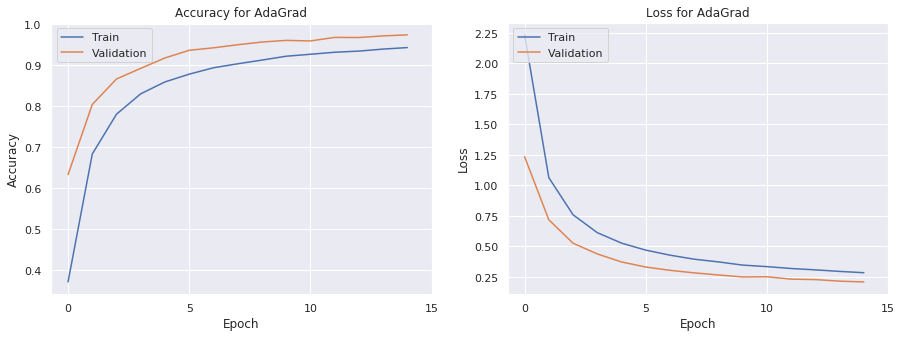

In [127]:
plot_metrics(history_adagrad, model_name = "AdaGrad")

### D. ADAM

In [0]:
top_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
history_adam = top_model.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 87s 91ms/step - loss: 1.4749 - acc: 0.6033 - val_loss: 0.6417 - val_acc: 0.8264
Epoch 2/15
952/952 [==============================] - 85s 89ms/step - loss: 0.4819 - acc: 0.8825 - val_loss: 0.3525 - val_acc: 0.9248
Epoch 3/15
952/952 [==============================] - 84s 88ms/step - loss: 0.3378 - acc: 0.9276 - val_loss: 0.3872 - val_acc: 0.9096
Epoch 4/15
952/952 [==============================] - 85s 90ms/step - loss: 0.2805 - acc: 0.9454 - val_loss: 0.2160 - val_acc: 0.9655
Epoch 5/15
952/952 [==============================] - 84s 89ms/step - loss: 0.2360 - acc: 0.9569 - val_loss: 0.2290 - val_acc: 0.9588
Epoch 6/15
952/952 [==============================] - 84s 88ms/step - loss: 0.2131 - acc: 0.9630 - val_loss: 0.1773 - val_acc: 0.9752
Epoch 7/15
952/952 [==============================] - 84s 88ms/step - loss: 0.1954 - acc: 0.9680 - val_loss: 0.1578 - val_acc: 0.9805
Epoch 8/15
952/952 [==============================] - 84s 88ms

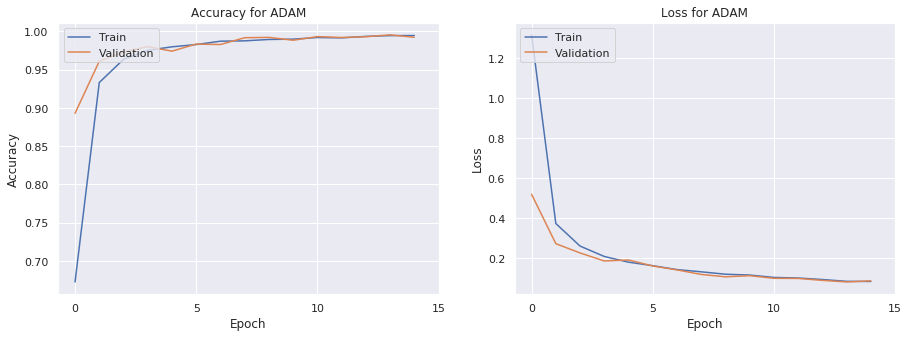

In [131]:
plot_metrics(history_adam, model_name = "ADAM")

### E. AdaMax

In [0]:
top_model.compile(loss='categorical_crossentropy', optimizer='adamax', metrics=['accuracy'])

In [134]:
history_adamax = top_model.fit_generator(train_generator, validation_data=validation_generator, epochs=15)

Epoch 1/15
952/952 [==============================] - 95s 100ms/step - loss: 1.5645 - acc: 0.6735 - val_loss: 0.6495 - val_acc: 0.8827
Epoch 2/15
952/952 [==============================] - 91s 96ms/step - loss: 0.4537 - acc: 0.9347 - val_loss: 0.3703 - val_acc: 0.9426
Epoch 3/15
952/952 [==============================] - 91s 96ms/step - loss: 0.2882 - acc: 0.9656 - val_loss: 0.2577 - val_acc: 0.9716
Epoch 4/15
952/952 [==============================] - 92s 96ms/step - loss: 0.2221 - acc: 0.9775 - val_loss: 0.2292 - val_acc: 0.9730
Epoch 5/15
952/952 [==============================] - 92s 97ms/step - loss: 0.1877 - acc: 0.9838 - val_loss: 0.1812 - val_acc: 0.9824
Epoch 6/15
952/952 [==============================] - 92s 96ms/step - loss: 0.1640 - acc: 0.9865 - val_loss: 0.1875 - val_acc: 0.9780
Epoch 7/15
952/952 [==============================] - 92s 97ms/step - loss: 0.1439 - acc: 0.9899 - val_loss: 0.1404 - val_acc: 0.9897
Epoch 8/15
952/952 [==============================] - 92s 97m

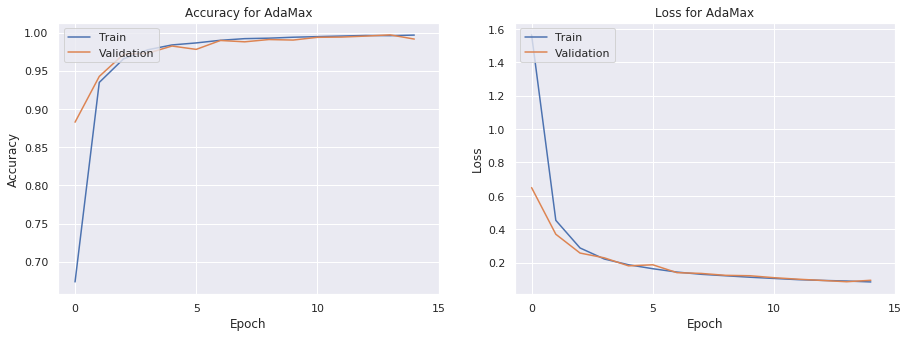

In [135]:
plot_metrics(history_adamax, model_name = "AdaMax")

### F. Running Best Model With Test Set 

In [0]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix

def conf_mat(y_test, y_pred):
    y_test_non_category = [ np.argmax(t) for t in y_test ]
    y_predict_non_category = [ np.argmax(t) for t in y_pred ]

    cm = confusion_matrix(y_test_non_category, y_predict_non_category)
    df_cm = pd.DataFrame(cm)
    plt.figure(figsize=(15,15))
    return sns.heatmap(df_cm, annot=False)

In [20]:
test_generator2 = data_generator.flow_from_directory(test_directory, target_size=(64, 64), batch_size=2000)

Found 13050 images belonging to 29 classes.


In [0]:
X, y = test_generator2.next()

In [22]:
np.array(X).shape

(2000, 64, 64, 3)

In [0]:
predictions = top_model.predict(X)

In [24]:
predictions

array([[1.31422441e-30, 8.58375354e-16, 3.11115951e-28, ...,
        4.96562599e-37, 0.00000000e+00, 5.66007877e-35],
       [1.47111772e-12, 9.80351698e-16, 2.83078200e-25, ...,
        1.78309895e-10, 1.59063081e-30, 2.90624255e-14],
       [6.29711737e-14, 1.67515148e-18, 2.01071337e-08, ...,
        1.56890644e-06, 1.04939733e-14, 3.61958185e-13],
       ...,
       [3.52028018e-17, 1.16070655e-08, 5.74734521e-22, ...,
        5.37577144e-12, 7.81525045e-14, 1.25117580e-07],
       [3.39568436e-15, 8.38123049e-20, 9.99997854e-01, ...,
        6.28102333e-24, 0.00000000e+00, 2.47151370e-26],
       [2.13419316e-05, 4.72385040e-07, 4.35142077e-20, ...,
        4.07790704e-20, 2.64976240e-27, 2.50769051e-13]], dtype=float32)

In [25]:
top_model.evaluate(X, y)

2000/2000 [==============================] - 0s 203us/step


[0.06913428455591202, 0.9895]

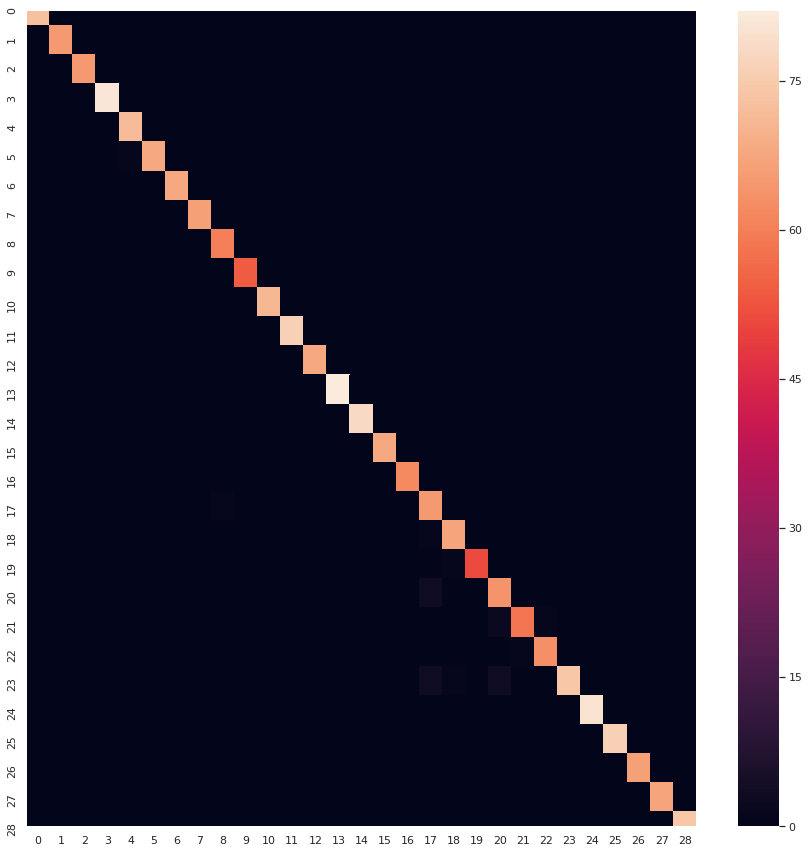

In [141]:
conf_mat(y, predictions)

In [0]:
y = [np.argmax(x) for x in y]

In [0]:
predictions = [np.argmax(x) for x in predictions]

## 5. Visualizing Channels and Filters of Best Results From Part Four

#### Our best performing model from part four was the RMSProp optimizer

In [145]:
from keras.models import load_model

model = load_model('rmsprop_model_top')
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 26, 26, 256)       295168    
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 13, 13, 256)       0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 43264)           

In [146]:
from keras.preprocessing import image

image_path = '/content/asl_alphabet/train/A/A1000.jpg'

img = image.load_img(image_path, target_size = (64, 64))
image_tensor = image.img_to_array(img)
image_tensor = np.expand_dims(image_tensor, axis = 0)
image_tensor /= 255.

print(image_tensor.shape)

(1, 64, 64, 3)


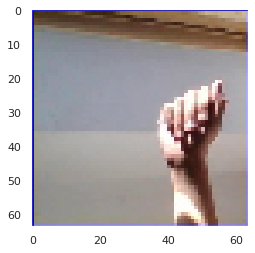

In [147]:
plt.imshow(image_tensor[0])
plt.grid(False)
plt.show()

In [0]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:6]]

activation_model = models.Model(inputs = model.input, 
                                outputs = layer_outputs)

activations = activation_model.predict(image_tensor)

In [149]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 62, 62, 64)


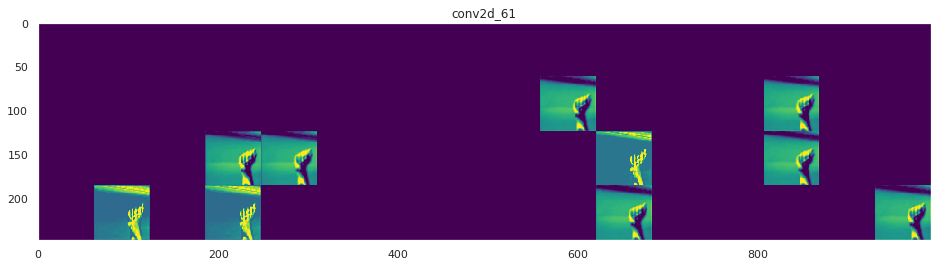

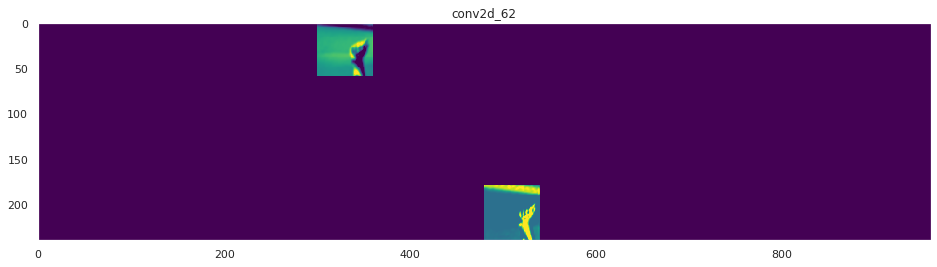

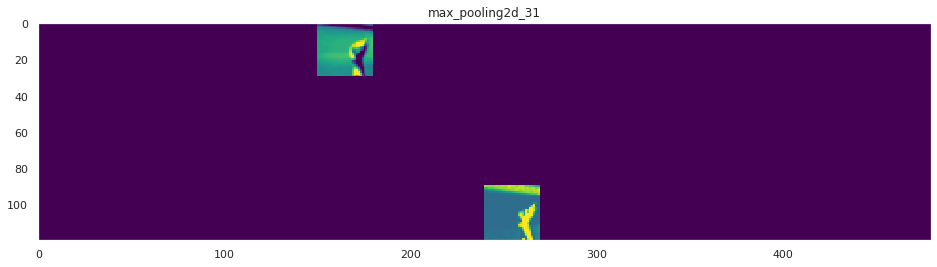

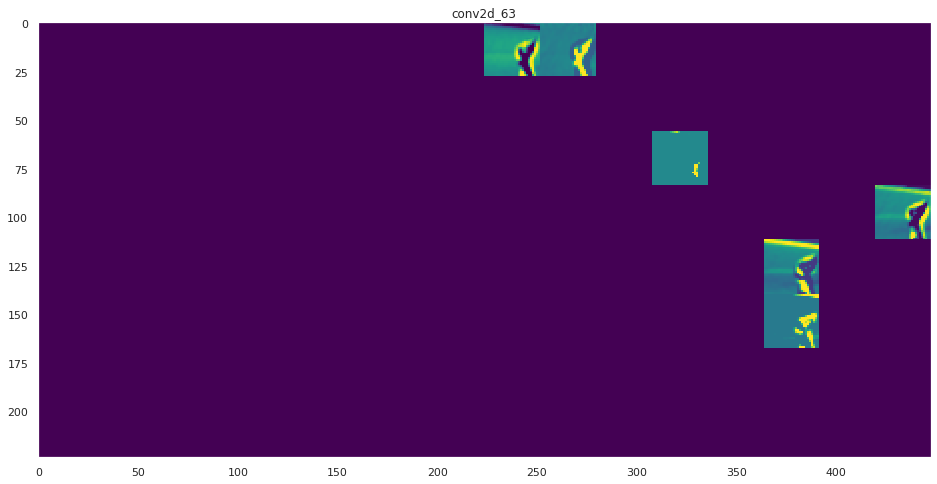

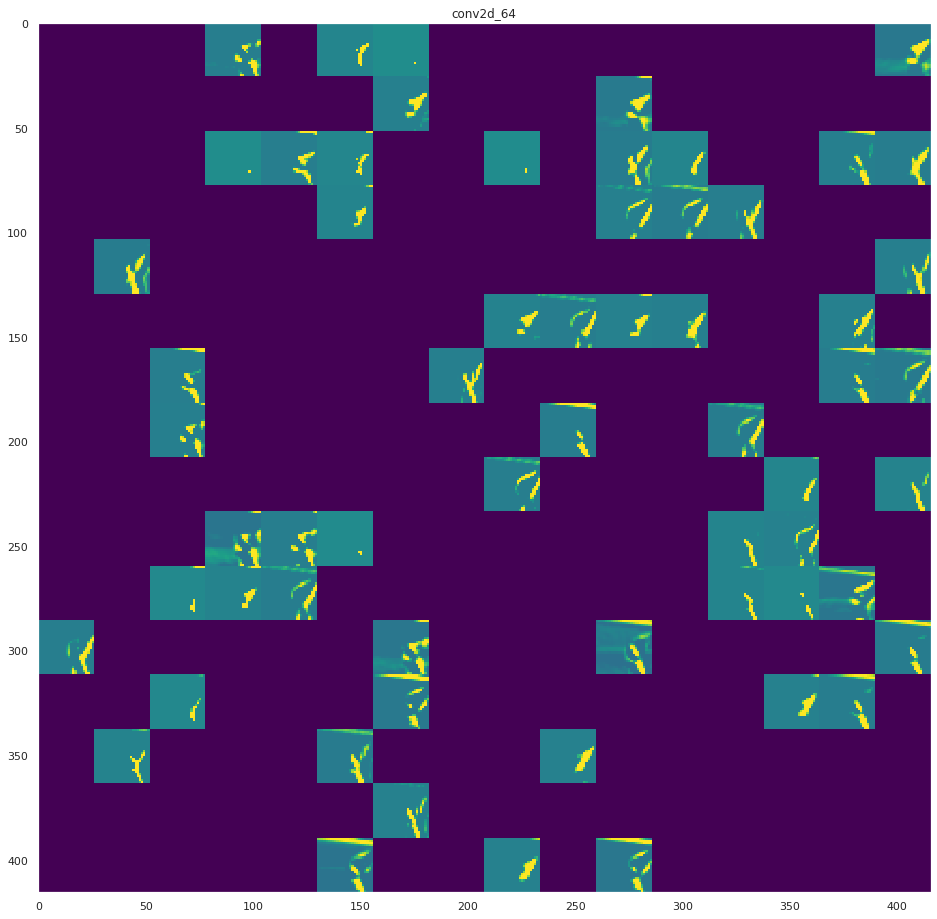

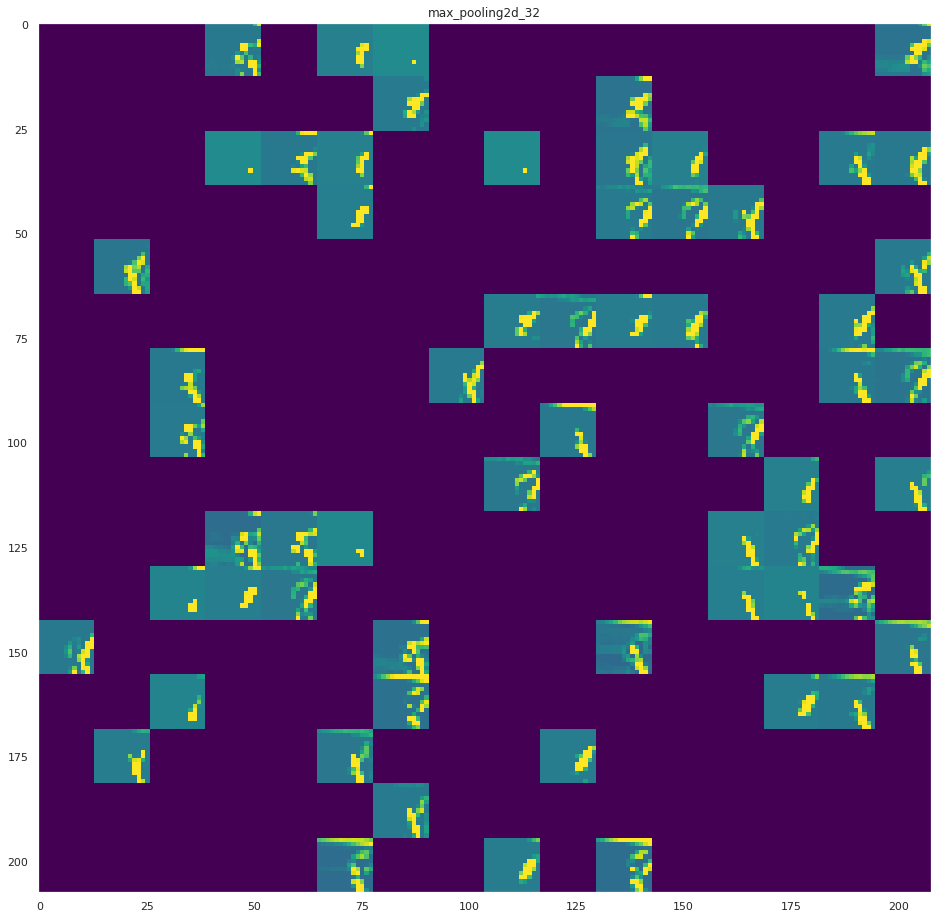

In [165]:
layer_names = []

for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, 
                         row * size : (row + 1) * size] = channel_image
            
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [0]:
from keras import backend as K

layer_name = 'conv2d_61'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [0]:
grads = K.gradients(loss, model.input)[0]

grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

iterate = K.function([model.input], [loss,grads])

loss_value, grads_value = iterate([np.zeros((1, 64, 64, 3))])

In [0]:
input_img_data = np.random.random((1, 64, 64, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [0]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0 ,255).astype('uint8')
    return x

def generate_pattern(layer_name, filter_index, size=64):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    grads = K.gradients(loss, model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input], [loss, grads])
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    step = 1
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

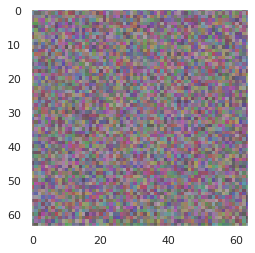

In [180]:
plt.imshow(generate_pattern('conv2d_61', 2))
plt.grid(False)

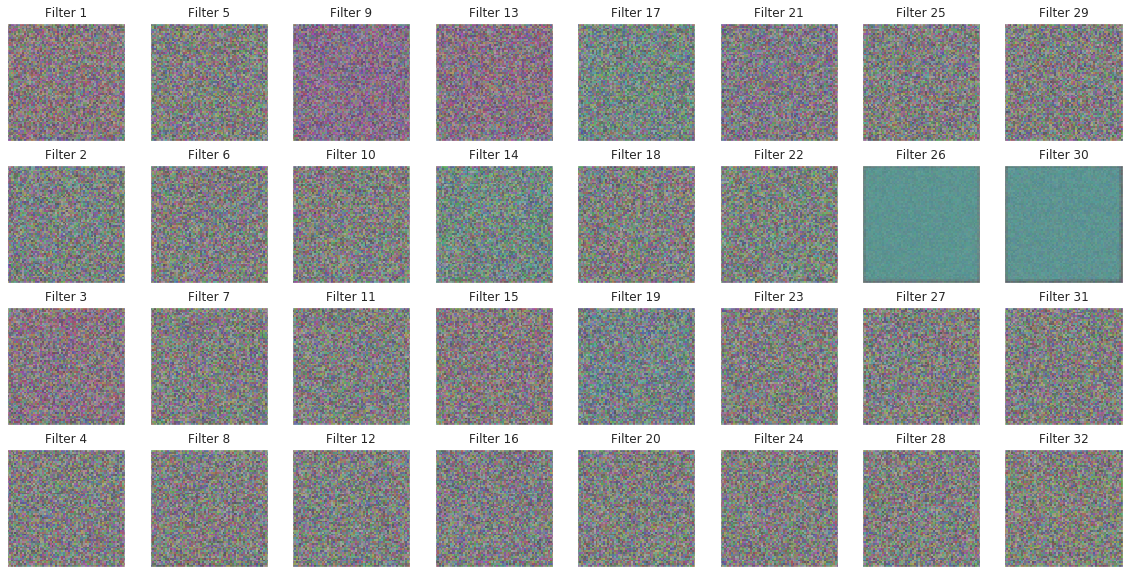

In [181]:
fig, axs = plt.subplots(4, 8, figsize = (20,10))

for i in range(4):
    for j in range(8):
        axs[i,j].grid(False)
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])
        axs[i,j].set_title(f"Filter {i + j*4 + 1}")
        axs[i,j].imshow(generate_pattern('conv2d_61', i + j*4, 64))

## 6. Preprocessing Tests with Grayscale Images

#### We preprocess our data by downscaling, converting to grayscale, and adding Gaussian and Sobel filters. We will run the new preprocessed data on our worst model to see if it improves performance by giving the model something else to learn with

In [0]:
import skimage as ski

imageSize=64
train_dir = '/content/asl_alphabet/train/'

from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['A']:
                label = 0
            elif folderName in ['B']:
                label = 1
            elif folderName in ['C']:
                label = 2
            elif folderName in ['D']:
                label = 3
            elif folderName in ['E']:
                label = 4
            elif folderName in ['F']:
                label = 5
            elif folderName in ['G']:
                label = 6
            elif folderName in ['H']:
                label = 7
            elif folderName in ['I']:
                label = 8
            elif folderName in ['J']:
                label = 9
            elif folderName in ['K']:
                label = 10
            elif folderName in ['L']:
                label = 11
            elif folderName in ['M']:
                label = 12
            elif folderName in ['N']:
                label = 13
            elif folderName in ['O']:
                label = 14
            elif folderName in ['P']:
                label = 15
            elif folderName in ['Q']:
                label = 16
            elif folderName in ['R']:
                label = 17
            elif folderName in ['S']:
                label = 18
            elif folderName in ['T']:
                label = 19
            elif folderName in ['U']:
                label = 20
            elif folderName in ['V']:
                label = 21
            elif folderName in ['W']:
                label = 22
            elif folderName in ['X']:
                label = 23
            elif folderName in ['Y']:
                label = 24
            elif folderName in ['Z']:
                label = 25
            elif folderName in ['del']:
                label = 26
            elif folderName in ['nothing']:
                label = 27
            elif folderName in ['space']:
                label = 28           
            for image_filename in (os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename)
                if img_file is not None:
                    img_file = ski.transform.resize(img_file, (imageSize, imageSize, 3))
                    img_file = ski.color.rgb2gray(img_file)
                    img_file = ski.filters.gaussian(img_file, sigma = 2)
                    img_file = ski.filters.sobel(img_file)
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y
X, y = get_data(train_dir)

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=1234)

In [0]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)

In [0]:
X_train = np.reshape(X_train, (51765, 64, 64, 1))

#### Our worst model had DropoutSize = 0.3, KernelSize=(3,3), and BatchNorm = True

In [0]:
model_worst = Sequential()
model_worst.add(Conv2D(64, input_shape=(64, 64, 1), kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_worst.add(BatchNormalization())
model_worst.add(Conv2D(64, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_worst.add(MaxPooling2D((2, 2)))
model_worst.add(BatchNormalization())
model_worst.add(Conv2D(128, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_worst.add(BatchNormalization())
model_worst.add(Conv2D(256, kernel_size=(3,3), kernel_regularizer=regularizers.l2(0.01), activation='relu'))
model_worst.add(MaxPooling2D((2, 2)))
model_worst.add(BatchNormalization())
model_worst.add(Flatten())
model_worst.add(Dropout(0.3))
model_worst.add(Dense(512, activation='relu'))
model_worst.add(Dense(29, activation='softmax'))

In [86]:
model_worst.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_65 (Conv2D)           (None, 62, 62, 64)        640       
_________________________________________________________________
batch_normalization_25 (Batc (None, 62, 62, 64)        256       
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
batch_normalization_26 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
batch_normalization_27 (Batc (None, 28, 28, 128)     

In [0]:
model_worst.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [88]:
history_worst = model_worst.fit(X_train, y_train, validation_split=0.15, epochs=15)

Train on 44000 samples, validate on 7765 samples
Epoch 1/15
44000/44000 [==============================] - 40s 916us/step - loss: 15.6764 - acc: 0.0517 - val_loss: 15.3479 - val_acc: 0.0569
Epoch 2/15
44000/44000 [==============================] - 36s 824us/step - loss: 15.2329 - acc: 0.0634 - val_loss: 15.1914 - val_acc: 0.0659
Epoch 3/15
44000/44000 [==============================] - 36s 817us/step - loss: 15.2075 - acc: 0.0649 - val_loss: 15.4138 - val_acc: 0.0527
Epoch 4/15
44000/44000 [==============================] - 36s 815us/step - loss: 15.0583 - acc: 0.0769 - val_loss: 15.1150 - val_acc: 0.0750
Epoch 5/15
44000/44000 [==============================] - 36s 813us/step - loss: 14.8801 - acc: 0.0885 - val_loss: 15.7682 - val_acc: 0.0343
Epoch 6/15
44000/44000 [==============================] - 36s 814us/step - loss: 14.7057 - acc: 0.0978 - val_loss: 15.4266 - val_acc: 0.0554
Epoch 7/15
44000/44000 [==============================] - 36s 815us/step - loss: 15.0863 - acc: 0.0752 - 

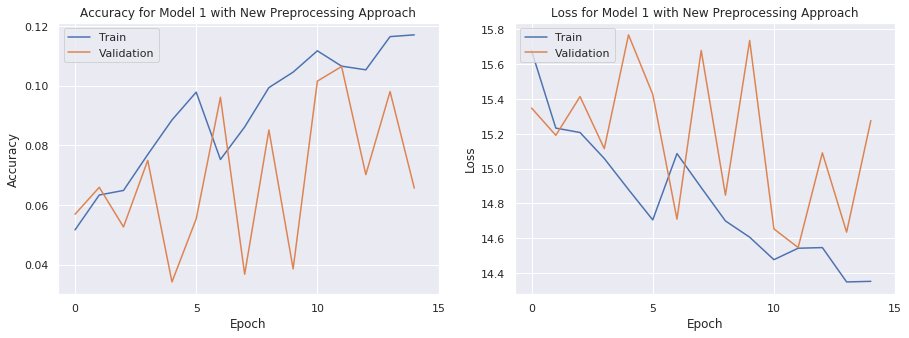

In [89]:
plot_metrics(history_worst, model_name = "Model 1 with New Preprocessing Approach")

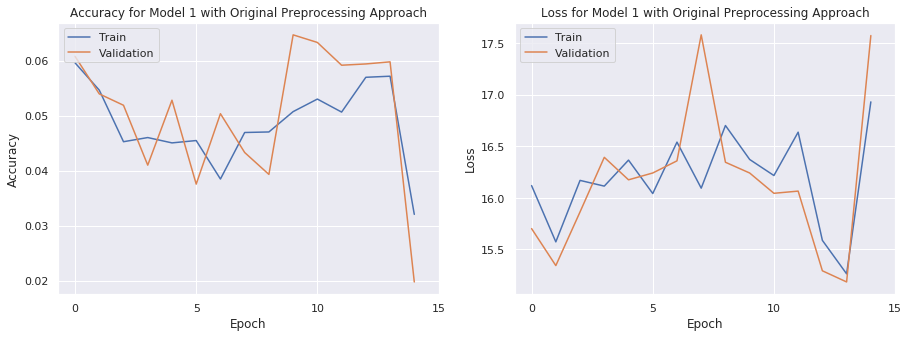

In [91]:
# Plot of Initial First Model for Comparison
plot_metrics(history1, model_name = "Model 1 with Original Preprocessing Approach")